## Setup

In [21]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


In [22]:
print(tf.__version__)

2.8.0


In [23]:
import pathlib
train_dir = 'data/Train/'
test_dir = 'data/Test/'
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)


# Load and preprocess images

There are 382 total images in train directory and 120 in test directory:

In [24]:
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

382
120


Each directory contains images of that type of disease. Here is an example of each of them:

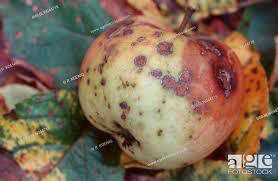

In [25]:
scab = list(train_dir.glob('Scab_Apple/*'))
PIL.Image.open(str(scab[4]))

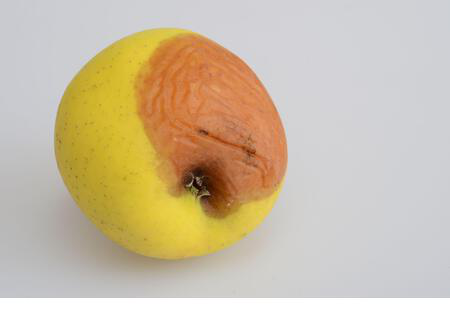

In [26]:
rot = list(train_dir.glob('Rot_Apple/*'))
PIL.Image.open(str(rot[1]))

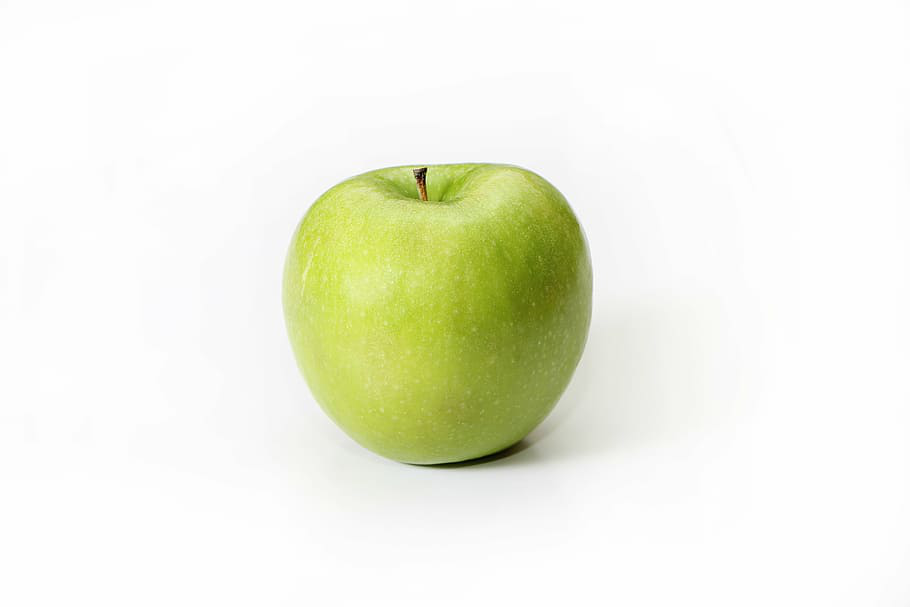

In [27]:
normal = list(train_dir.glob('Normal_Apple/*'))
PIL.Image.open(str(normal[1]))

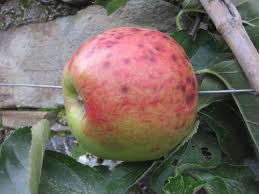

In [28]:

blotch = list(train_dir.glob('Blotch_Apple/*'))
PIL.Image.open(str(blotch[0]))

### Create a dataset

Parameters:

In [29]:
img_height = 360
img_width = 360
batch_size = 32

Train / Validation split

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# You can print the length of each dataset as follows: from load and preprocess images tutorial notebook
print(tf.data.experimental.cardinality(train_ds).numpy())

Found 382 files belonging to 4 classes.
Using 306 files for training.
10


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# You can print the length of each dataset as follows: from load and preprocess images tutorial notebook
print(tf.data.experimental.cardinality(val_ds).numpy())

Found 382 files belonging to 4 classes.
Using 76 files for validation.
3


Test

In [32]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
# You can print the length of each dataset as follows: from load and preprocess images tutorial notebook
print(tf.data.experimental.cardinality(test_ds).numpy())

Found 120 files belonging to 4 classes.
4


class names in the `class_names` attribute:

In [33]:
class_names = train_ds.class_names
print(class_names)

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


### Visualize the data

Here are the first 16 images from the training dataset.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [35]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [36]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [ ]:
# AUTOTUNE IS EEN EXPIRIMENT VOOR LATER, ZORGT ER NU VOOR DAT MODEL NIET GOED LAADT VOOR TRAINING

# AUTOTUNE = tf.data.AUTOTUNE 

# # train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# # val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

# train_ds = configure_for_performance(train_ds)
# val_ds = configure_for_performance(val_ds)
# test_ds = configure_for_performance(test_ds)

In [37]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [38]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [40]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
10/10 [==============================] - 14s 1s/step - loss: 0.5230 - accuracy: 0.8072 - val_loss: 0.6810 - val_accuracy: 0.7500
Epoch 2/3
10/10 [==============================] - 14s 1s/step - loss: 0.4019 - accuracy: 0.8562 - val_loss: 0.8207 - val_accuracy: 0.7368
Epoch 3/3
10/10 [==============================] - 14s 1s/step - loss: 0.2325 - accuracy: 0.9281 - val_loss: 0.8441 - val_accuracy: 0.7368


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.